In [2]:
# Starter code for the Coursera SDC Course 2 final project.
#
# Author: Trevor Ablett and Jonathan Kelly
# University of Toronto Institute for Aerospace Studies
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
f = open('data/pt1_data.pkl', 'rb')
data = pickle.load(f)

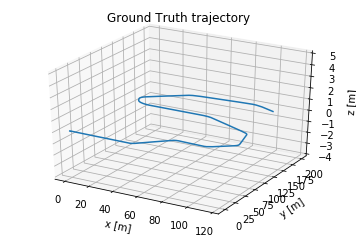

(521, 3)

In [ ]:
gt = data['gt']         # Data object containing ground truth
imu_f = data['imu_f']   # imu_f.data, imu_f.t are IMU force data and timestamps (given in vehicle frame)
imu_w = data['imu_w']   # imu rotational velocity (given in the vehicle frame)
gnss = data['gnss']     # StampedData object with the GNSS data.
lidar = data['lidar']   # StampedData object with the LIDAR data (positions only)

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-4, 5)
plt.show()

lidar.data


## Motion model 

<table>
<tr>
<td> <img src="i/f.png" alt="motion model" width="800"/> </td>
</tr>
<tr>
<td> <img src="i/f_linear.png" alt="motion model" width="800"/> </td>
</tr>
</tr></table>

<table><tr>
<td> <img src="i/h1.png" alt="sensor model - GPS" width="500"/> </td>
<td> <img src="i/h2.png" alt="sensor model - LIDAR" width="500"/> </td>
</tr></table>


Remember that our LIDAR data is actually just a set of positions estimated from a separate scan-matching system, so we can insert it into our solver 

### Calibration rotation matrix

- Our LIDAR data is a set of positions estimated from a separate scan-matching system. 
- The LIDAR frame is not the same as the frame shared by the IMU and the GNSS. 
- We need to transform the LIDAR data to the IMU frame using our a known extrinsic calibration rotation matrix $C_{li}$ and translation vector $t^{i}_{li} $



In [7]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

# Translation vector from lidar frame to vehicle frame 
t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

In [8]:
lidar.data[1:3]

array([[ 0.69285988, -0.21417443,  0.67438022],
       [ 0.33522633, -0.61852294,  0.98018279]])

In [6]:
lidar.data[1:3]

array([[ 0.15161577, -0.32233794,  0.19854545],
       [-0.25938716, -0.67422769,  0.50213139]])

In [64]:
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian

h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


### Initial Values 

In [66]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate

gnss_i  = 0
lidar_i = 0


array([ 9.99999999e-01, -2.05063223e-05, -3.39150521e-05,  5.31936712e-07])

### Main Filter Loop

In [ ]:
def f1(pk1, vk1, fk1, dt):
    # position at time k
    p_k_check = np.zeros([3, 1])
    p_k_check = pk1 + dt*vk1 + 0.5*dt*dt * () 

In [ ]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain

    # 3.2 Compute error state

    # 3.3 Correct predicted state

    # 3.4 Compute corrected covariance

    return p_hat, v_hat, q_hat, p_cov_hat

for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs

    # 1.1 Linearize the motion model and compute Jacobians

    # 2. Propagate uncertainty

    # 3. Check availability of GNSS and LIDAR measurements

    # Update states (save)
    


In [ ]:
#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()